In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import time
import copy
import collections
import scipy as sp
import numpy as np
import pandas as pd
import pickle as pkl

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.reload_library()
plt.style.use(['science'])

In [3]:
import ro.params as ro_params

from ro.utils import load_instance
from ro.utils.kp import get_path
from ro.two_ro.kp import Knapsack

### Functions

In [4]:
def get_results(result_dir, algo_type):
    """ Gets results for specific algorithm type from specified directory.  """
    opt_type, obj_type = algo_type.split("-")
    
    # filter files for files for algorithm type
    files = os.listdir(result_dir)
    files = list(filter(lambda x: 'results' in x, files))  
    
    if opt_type == "A":
        files = list(filter(lambda x: 'opt-adversarial' in x, files))
    elif opt_type == "S":
        files = list(filter(lambda x: 'opt-sampling' in x, files))
        
    if obj_type == "AM":
        files = list(filter(lambda x: 'obj-argmax' in x, files))
    elif obj_type == "M":
        files = list(filter(lambda x: 'obj-max' in x, files))
    
    # append directory
    files = list(map(lambda x: result_dir + x, files))
    
    # load results for all files
    results = {}
    for n_items in [20,30,40,50,60,70,80]:
        results[n_items] = []

    for file in files:
        with open(file, 'rb') as p:
            file_res = pkl.load(p)
            n_items = len(file_res['opt_stats']['xi_added'][0])
            results[n_items].append(file_res)
        
    return results

In [5]:
def geo_mean(iterable):
    a = np.array(iterable)
    return a.prod()**(1.0/len(a))

In [6]:
def get_inst_agg_results(results, n_items, inst_type, paper_time_limit=3 * 3600.00):
    """  """
    res = list(filter(lambda x: f"_{inst_type}_" in x['inst_name'], results[n_items]))
    # remove empty entries from evaluation not working
    n_no_sol = len(list(filter(lambda x: x['algo_obj'] is None, res)))
    res = list(filter(lambda x: x['algo_obj'] is not None, res))

    # gap between baseline and algo
    gap = list(map(lambda x: 100 * (x['baseline_obj'] - x['algo_obj'])/x['baseline_obj'], res))
    gap_mean = np.mean(gap)
    
    # get best known sol
    best_obj = []
    for i in range(len(res)):
        best_obj.append(max(res[i]['baseline_obj'], res[i]['algo_obj']))

    re_ml = list(map(lambda x, y: 100 * abs(y - x['algo_obj'] )/abs(y), res, best_obj ))
    re_baseline = list(map(lambda x, y: 100 * abs(y - x['baseline_obj'])/abs(y), res, best_obj ))

    # algorithm time
    time_algo = list(map(lambda x: x['algo_time'], res))
    time_algo_mean = np.mean(time_algo)

    # get baseline time
    time_baseline = list(map(lambda x: x['baseline_time'], res))
    n_limits = len(list(filter(lambda x: x == 'TIME_LIMIT', time_baseline)))

    # replace limit with value, and convert to floats
    time_baseline = list(map(lambda x: paper_time_limit if x == 'TIME_LIMIT' else x, time_baseline))
    time_baseline = list(map(lambda x: float(x), time_baseline))
    time_baseline_mean = np.mean(time_baseline)

    # time ratio
    time_ratio = list(map(lambda x, y: x / y, time_baseline, time_algo))
    time_ratio_mean = np.mean(time_ratio)
    
    # number of scenarios added
    n_scenarios = np.mean(list(map(lambda x: len(x['opt_stats']['xi_added']), res)))
    
    
    inst_results = {
        "gap" : gap,
        "time_algo" : time_algo,
        "time_baseline" : time_baseline,
        "time_ratio" : time_ratio,
        
        "n_limits" : n_limits,
        "mean_gap" : gap_mean,
        "mean_time_baseline" : time_baseline_mean,
        "mean_time_algo" : time_algo_mean,      
        
        "re_ml" : re_ml,
        "re_ml_mean" : np.mean(re_ml),
        "re_ml_median" : np.median(re_ml),
        "re_ml_q1" : np.percentile(re_ml, 25),
        "re_ml_q3" : np.percentile(re_ml, 75),
        "re_baseline" : re_baseline,
        "re_baseline_mean" : np.mean(re_baseline),
        "re_baseline_median" : np.median(re_baseline),
        "re_baseline_q1" : np.percentile(re_baseline, 25),
        "re_baseline_q3" : np.percentile(re_baseline, 75),
        
        'n_scenarios' : n_scenarios, 
    }
    
    return inst_results

In [7]:
def latex_main_results(df_, corr_type):
    """ Generate Latex table for combined results.  """

    df = df_.copy()

    df = df.rename(columns={
        'mre-ml' : '\\method{}',
        'mre-baseline' : 'BP',
        'time-A-AM' : '\\method{}\ ',
        'time-baseline' : 'BP\ ',
       })
    
    df = df.style.format(thousands=',', formatter = 
        {'\\method{}'     : '{:.3f}'.format,
         'BP'             : '{:.3f}'.format,
         '\\method{}\ '   : '{:.0f}'.format,
         'BP\ '           : '{:.0f}'.format,
        })
        
    df = df.highlight_min(subset=['\\method{}', 'BP'], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=['\\method{}\ ', 'BP\ '], props='textbf:--rwrap;', axis=1)
    
    end_str = '}\n\\caption{Knapsack: Gaps and times for all instances.  All times in seconds.}\n'
    end_str += '\\label{tab:kp_results}\n'
    end_str += '\\end{table*}' 

    latex_str = df.to_latex(column_format='l|rr|rr').replace('_','\_').replace('nan', '-').replace('#', '\#')
    
    latex_str2 = (latex_str.splitlines())
    latex_str2.insert(1, '\\toprule')
    latex_str2.insert(2, '\# items & \multicolumn{2}{c|}{MRE (\%)}  &  \multicolumn{2}{c}{Times} \\\\')
    latex_str2.insert(4, '\\midrule')
    latex_str2.insert(-1, '\\bottomrule')
    latex_str2.insert(0, '\\begin{table*}[h]\\centering\\resizebox{0.8\\textwidth}{!}{')
    latex_str2[-1] += end_str #'}\end{table*}'#.insert(-1, '\\end{tabular}}')

    print("\n".join(latex_str2))
    print()

In [8]:
def get_main_paper_df(results, inst_type, algo_type, tol=5e-4, use_median=True):
    # rows and columns of dataframe
    n_items = [20, 30, 40, 50, 60, 70, 80]
    cols = ["mre-ml", "mre-baseline", f"time-{algo_type}", "time-baseline", ]
    
    df = pd.DataFrame(columns=cols, index=n_items)

    for n_item in n_items:
        n_item_res = get_inst_agg_results(results, n_item, inst_type)
        
        if use_median:
            df["mre-ml"][n_item] = n_item_res['re_ml_median']
            df["mre-baseline"][n_item] = n_item_res['re_baseline_median']
        else:
            df["mre-ml"][n_item] = n_item_res['re_ml_mean']
            df["mre-baseline"][n_item] = n_item_res['re_baseline_mean']  
            
        n_better = np.sum((np.array(n_item_res['gap']) < - tol))
        pct_better = 100 * n_better / len(list(np.array(n_item_res['gap'])))
        #df["ml-better"][n_item] = pct_better
        df[f"time-{algo_type}"][n_item] = n_item_res['mean_time_algo']
        df["time-baseline"][n_item] = n_item_res['mean_time_baseline']
        
    return df

In [9]:
def get_main_paper_df_extended(results, inst_type, algo_type, tol=5e-4):
    # rows and columns of dataframe
    n_items = [20, 30, 40, 50, 60, 70, 80]
    cols = ["mean-re-ml", "mean-re-baseline",
            "median-re-ml", "median-re-baseline",
            "q1-re-ml", "q1-re-baseline",
            "q3-re-ml", "q3-re-baseline" ]
    
    df = pd.DataFrame(columns=cols, index=n_items)

    for n_item in n_items:
        n_item_res = get_inst_agg_results(results, n_item, inst_type)
        
        df["mean-re-ml"][n_item] = n_item_res['re_ml_mean']
        df["mean-re-baseline"][n_item] = n_item_res['re_baseline_mean']
        
        df["median-re-ml"][n_item] = n_item_res['re_ml_median']
        df["median-re-baseline"][n_item] = n_item_res['re_baseline_median']
        
        df["q1-re-ml"][n_item] = n_item_res['re_ml_q1']
        df["q1-re-baseline"][n_item] = n_item_res['re_baseline_q1']
        
        df["q3-re-ml"][n_item] = n_item_res['re_ml_q3']
        df["q3-re-baseline"][n_item] = n_item_res['re_baseline_q3']
        
    return df

In [10]:
def latex_main_results_extended(df_):
    """ Generate Latex table for combined results.  """

    df = df_.copy()

    df = df.style.format(thousands=',', precision=3)    
    
    df = df.highlight_min(subset=['mean-re-ml', 'mean-re-baseline'], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=['median-re-ml', 'median-re-baseline'], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=['q1-re-ml', 'q1-re-baseline'], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=['q3-re-ml', 'q3-re-baseline'], props='textbf:--rwrap;', axis=1)
    
    end_str = '}\n\\caption{Knapsack: Extended table}\n'
    end_str += '\\label{tab:kp_ext}\n'
    end_str += '\\end{table*}' 
    
    latex_str = df.to_latex(column_format='l|rr|rr|rr|rr').replace('_','\_').replace('nan', '-').replace('#', '\#')
    
    latex_str2 = (latex_str.splitlines())
    latex_str2.insert(1, '\\toprule')
    latex_str2.insert(3, '\\midrule')
    latex_str2.insert(-1, '\\bottomrule')
    latex_str2.insert(0, '\\begin{table*}[h]\\centering\\resizebox{0.8\\textwidth}{!}{')
    latex_str2[-1] += end_str #'}\end{table*}'#.insert(-1, '\\end{tabular}}')

    print("\n".join(latex_str2))
    print()

## Data Directory

In [11]:
data_dir = '../data/'

In [12]:
problem = 'kp'
cfg = getattr(ro_params, problem)

In [13]:
fp_inst = get_path(data_dir, cfg, "inst")
fp_data = get_path(data_dir, cfg, "ml_data")
fp_nn = get_path(data_dir, cfg, "nn_tiny_set")
fp_nn_res = get_path(data_dir, cfg, "nn_tiny_set_tr_res")

In [14]:
result_dir = data_dir + problem + '/'

In [15]:
results = get_results(result_dir, 'A-AM')

# Main paper: Tables

In [16]:
mp_un = get_main_paper_df(results, 'UN', 'A-AM')
mp_wc = get_main_paper_df(results, 'WC', 'A-AM')
mp_asc = get_main_paper_df(results, 'ASC', 'A-AM')
mp_sc = get_main_paper_df(results, 'SC', 'A-AM')

In [17]:
latex_main_results(mp_un, 'UN')

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr}
\toprule
\# items & \multicolumn{2}{c|}{MRE (\%)}  &  \multicolumn{2}{c}{Times} \\
 & \method{} & BP & \method{}\  & BP\  \\
\midrule
20 & 1.417 & \textbf{0.000} & 7 & \textbf{0} \\
30 & 1.188 & \textbf{0.000} & 9 & \textbf{1} \\
40 & 1.614 & \textbf{0.000} & 13 & \textbf{3} \\
50 & 1.814 & \textbf{0.000} & 14 & \textbf{12} \\
60 & 1.146 & \textbf{0.000} & 24 & \textbf{18} \\
70 & 1.408 & \textbf{0.000} & \textbf{27} & 46 \\
80 & 0.994 & \textbf{0.000} & \textbf{20} & 388 \\
\bottomrule
\end{tabular}}
\caption{Knapsack: Gaps and times for all instances.  All times in seconds.}
\label{tab:kp_results}
\end{table*}



In [18]:
latex_main_results(mp_wc, 'WC')

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr}
\toprule
\# items & \multicolumn{2}{c|}{MRE (\%)}  &  \multicolumn{2}{c}{Times} \\
 & \method{} & BP & \method{}\  & BP\  \\
\midrule
20 & 1.705 & \textbf{0.000} & \textbf{7} & 29 \\
30 & 2.236 & \textbf{0.000} & \textbf{16} & 454 \\
40 & 1.667 & \textbf{0.000} & \textbf{45} & 6179 \\
50 & 1.756 & \textbf{0.000} & \textbf{42} & 8465 \\
60 & 0.772 & \textbf{0.000} & \textbf{134} & 9242 \\
70 & 0.068 & \textbf{0.020} & \textbf{32} & 10800 \\
80 & \textbf{0.000} & 0.345 & \textbf{45} & 10800 \\
\bottomrule
\end{tabular}}
\caption{Knapsack: Gaps and times for all instances.  All times in seconds.}
\label{tab:kp_results}
\end{table*}



In [19]:
latex_main_results(mp_asc, 'ASC')

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr}
\toprule
\# items & \multicolumn{2}{c|}{MRE (\%)}  &  \multicolumn{2}{c}{Times} \\
 & \method{} & BP & \method{}\  & BP\  \\
\midrule
20 & 1.798 & \textbf{0.000} & \textbf{7} & 9 \\
30 & 0.627 & \textbf{0.000} & \textbf{10} & 2708 \\
40 & 0.497 & \textbf{0.000} & \textbf{17} & 4744 \\
50 & 0.019 & \textbf{0.000} & \textbf{13} & 8852 \\
60 & 0.047 & \textbf{0.000} & \textbf{27} & 10261 \\
70 & \textbf{0.031} & 0.031 & \textbf{34} & 10800 \\
80 & 0.106 & \textbf{0.035} & \textbf{26} & 10800 \\
\bottomrule
\end{tabular}}
\caption{Knapsack: Gaps and times for all instances.  All times in seconds.}
\label{tab:kp_results}
\end{table*}



In [20]:
latex_main_results(mp_sc, 'SC')

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr}
\toprule
\# items & \multicolumn{2}{c|}{MRE (\%)}  &  \multicolumn{2}{c}{Times} \\
 & \method{} & BP & \method{}\  & BP\  \\
\midrule
20 & 1.774 & \textbf{0.000} & \textbf{8} & 9 \\
30 & 0.670 & \textbf{0.000} & \textbf{11} & 2473 \\
40 & 0.542 & \textbf{0.000} & \textbf{20} & 5665 \\
50 & 0.073 & \textbf{0.000} & \textbf{18} & 8240 \\
60 & \textbf{0.000} & 0.046 & \textbf{21} & 10800 \\
70 & \textbf{0.020} & 0.027 & \textbf{28} & 10800 \\
80 & \textbf{0.000} & 0.032 & \textbf{31} & 10800 \\
\bottomrule
\end{tabular}}
\caption{Knapsack: Gaps and times for all instances.  All times in seconds.}
\label{tab:kp_results}
\end{table*}



# Appendix: Boxplot

In [21]:
def boxplot_for_corr_type(corr_type, fontsize=16):
    
    colors = ['#8DDFCB', '#82A0D8']
    #colors = ['#ECEE81', '#8DDFCB']# , '#82A0D8', '#EDB7ED']
    # ['#ECEE81', '#8DDFCB']
    results = get_results(result_dir, 'A-AM')
    
    re = {}
    re['ml'] = [] 
    re['baseline'] = []

    for n_items in cfg.n_items:
        re['ml'].append(get_inst_agg_results(results, n_items, corr_type)['re_ml'])
        re['baseline'].append(get_inst_agg_results(results, n_items, corr_type)['re_baseline'])
        
    # combine data
    data_groups = [re['ml'], re['baseline']]

    # labels
    labels = ['20', '30', '40', '50', '60', '70', '80']

    # widths
    width       = 1/len(labels)
    xlocations  = [ x*((1+ len(data_groups))*width) for x in range(len(data_groups[0])) ]

    ymin        = min ( [ val  for dg in data_groups  for data in dg for val in data ] )
    ymax        = max ( [ val  for dg in data_groups  for data in dg for val in data ])
    
    with plt.style.context(['science', 'nature', 'bright']):

        fig, ax = plt.subplots(figsize=(14,4), dpi=300)

        ax = plt.gca()

        space = len(data_groups)/2
        offset = len(data_groups)/2

        # --- Offset the positions per group:

        group_positions = []
        for num, dg in enumerate(data_groups):    
            _off = (0 - space + (0.5+num))
            group_positions.append([x+_off*(width+0.01) for x in xlocations])

        for dg, pos, c in zip(data_groups, group_positions, colors):
            boxes = ax.boxplot(dg, 
                        labels=['']*len(labels),
                        positions=pos, 
                        widths=width, 
                        boxprops=dict(facecolor=c),                    
                        patch_artist=True)

        # legends
        custom_lines = [Line2D([0], [0], color=colors[0], lw=4),
                        Line2D([0], [0], color=colors[1], lw=4),]
        ax.legend(custom_lines,['\\texttt{Neur2RO}', 'BP'], fontsize=fontsize)

        #plt.axhline(y=0.0, color='lightgrey', linestyle='-')

        ax.set_xticks(xlocations, fontsize=fontsize)
        ax.set_xticklabels(labels, rotation=0)

        ax.set_ylabel('RE', fontsize=fontsize)
        ax.set_xlabel('\# Items', fontsize=fontsize)

        plt.yticks(fontsize=fontsize)  
        plt.xticks(fontsize=fontsize)    
        
        plt.show()

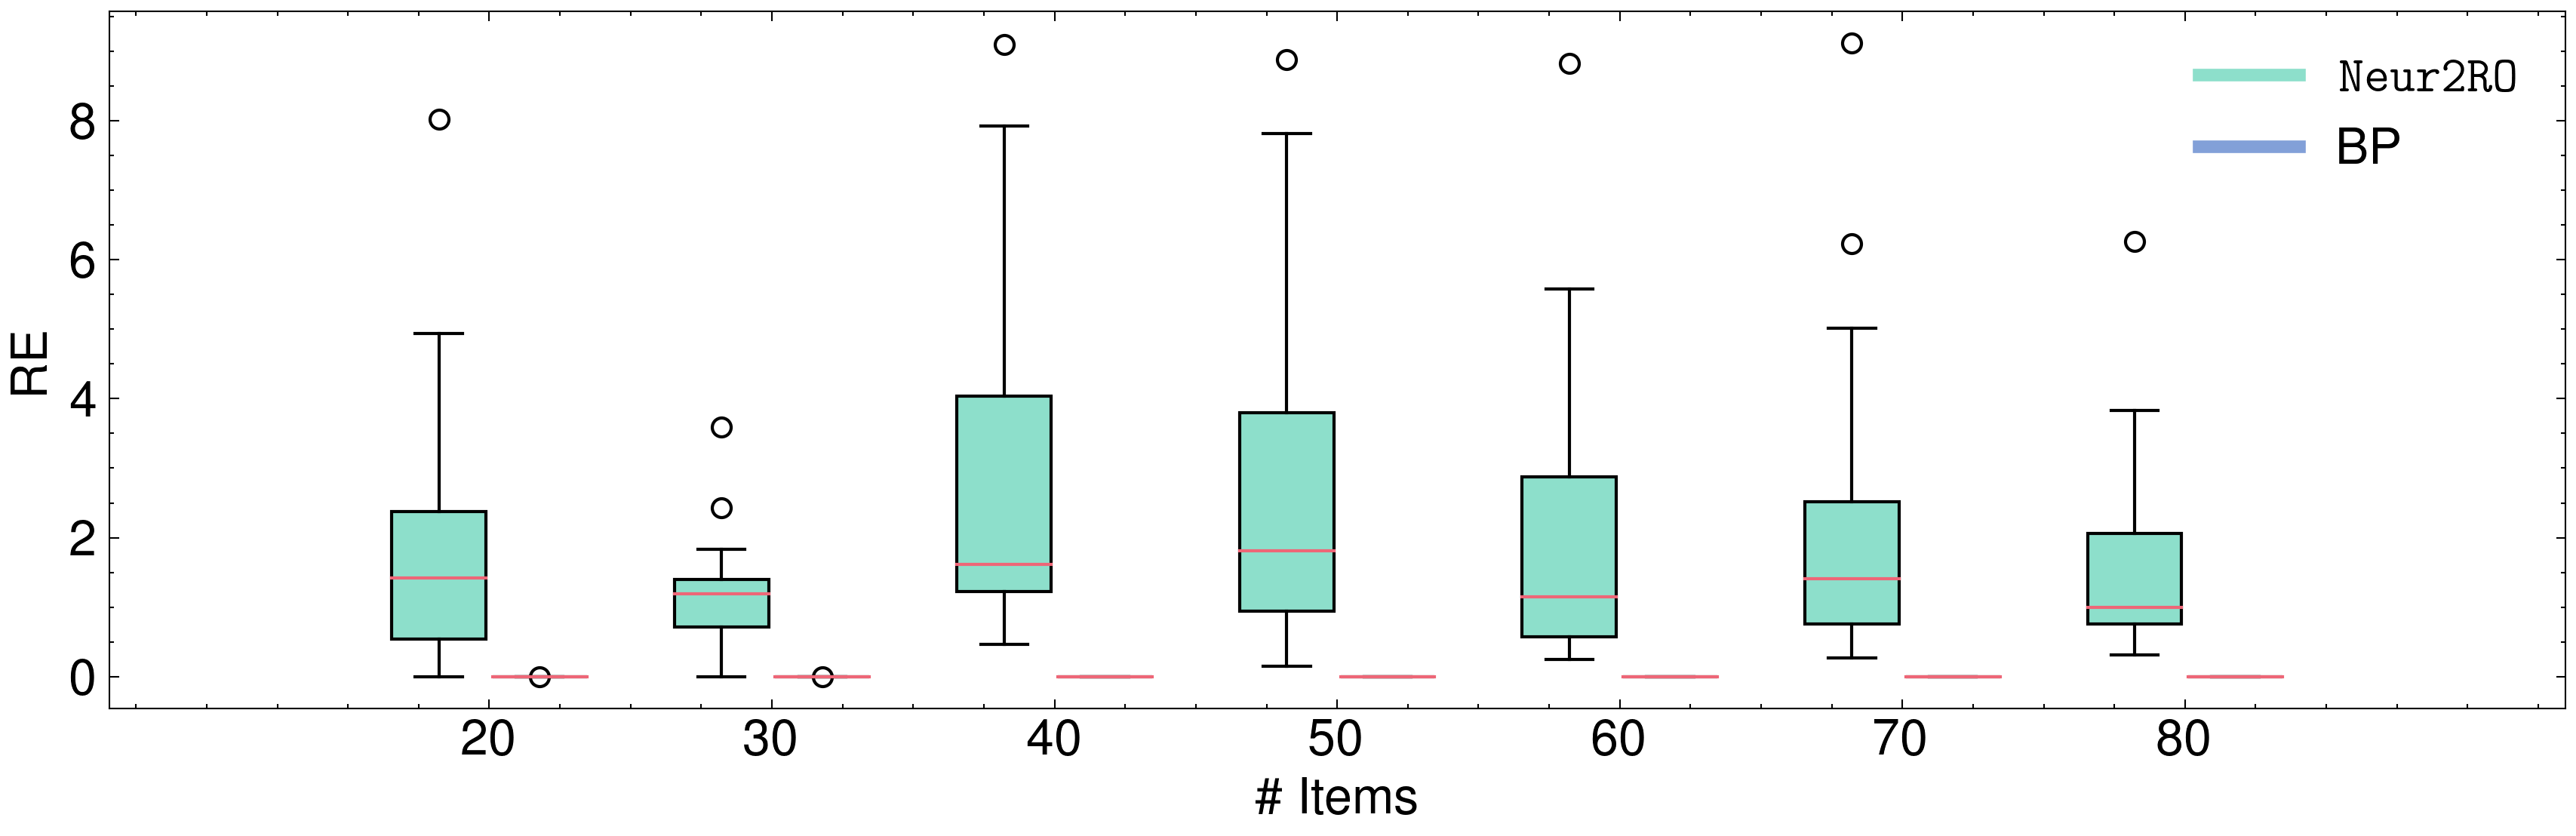

In [22]:
boxplot_for_corr_type("UN")

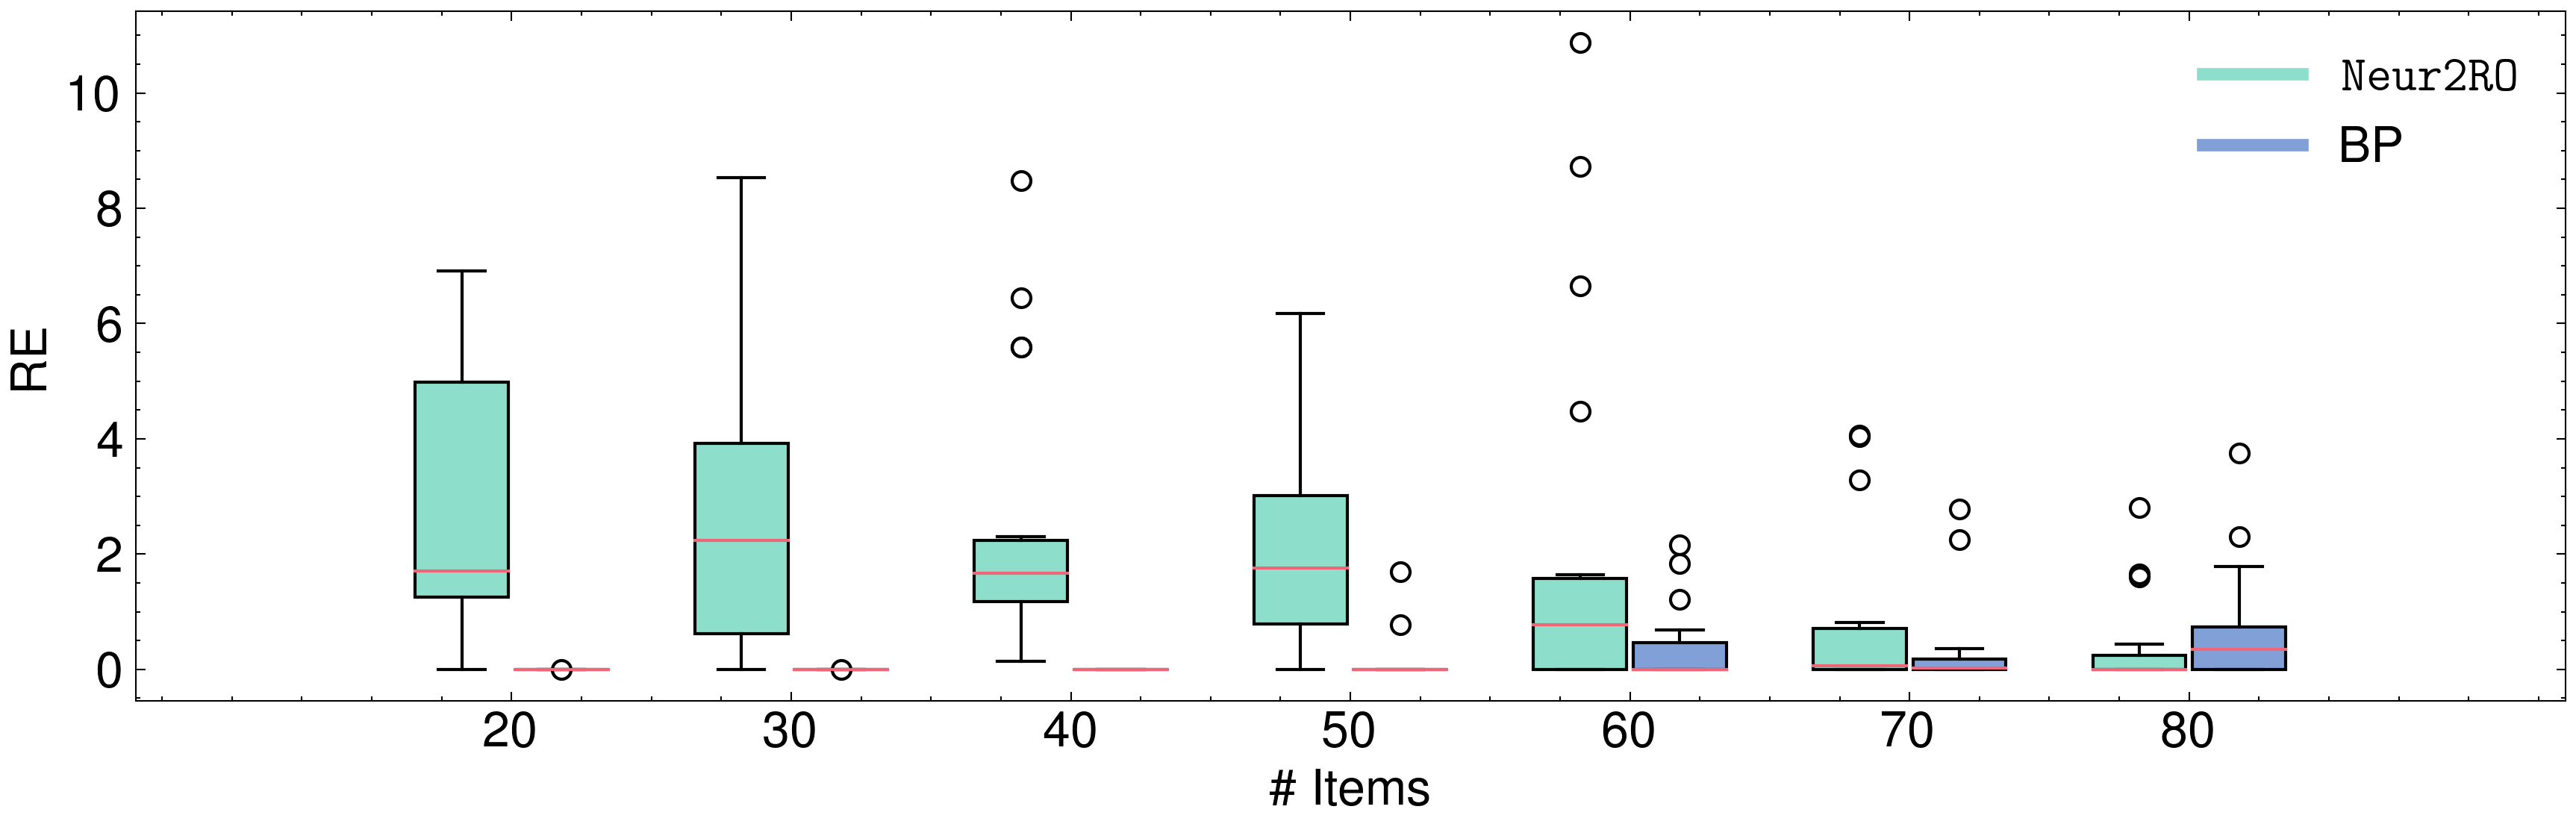

In [23]:
boxplot_for_corr_type("WC")

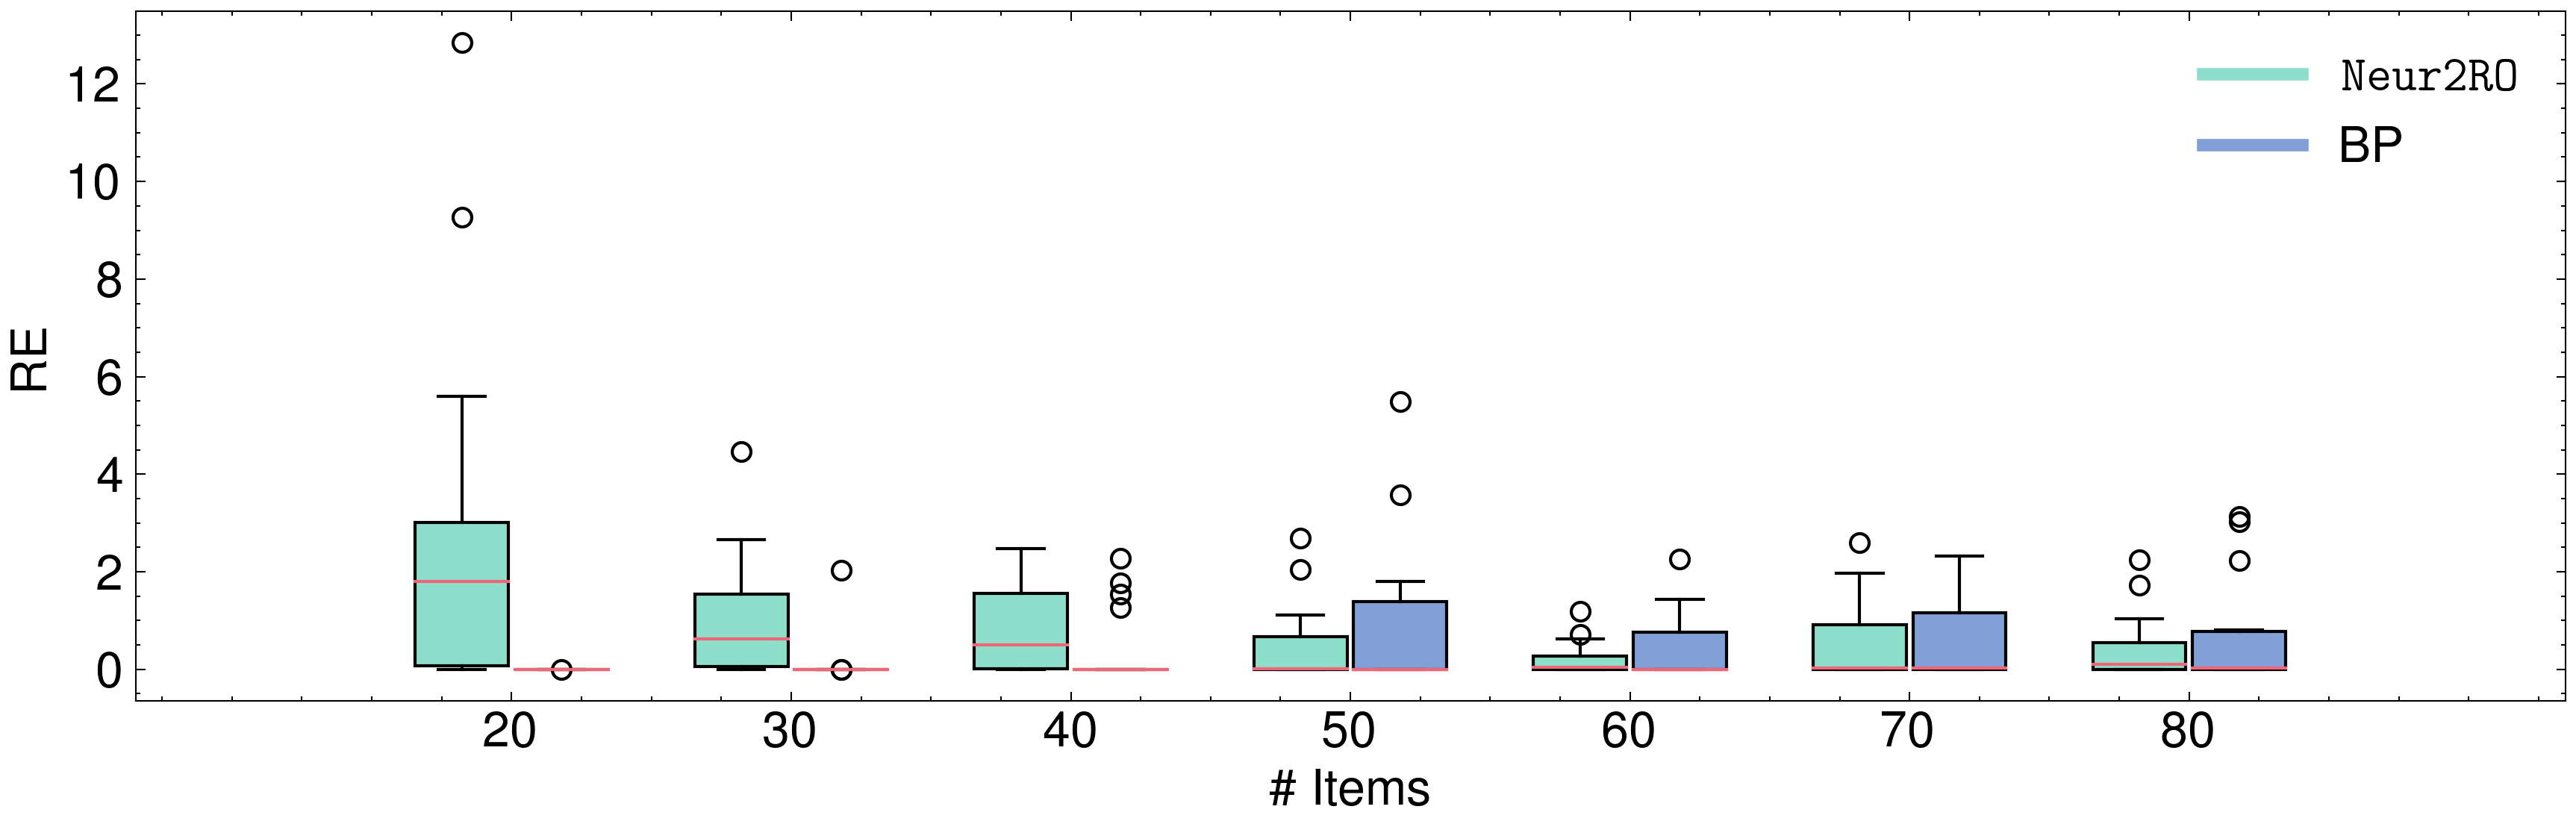

In [24]:
boxplot_for_corr_type("ASC")

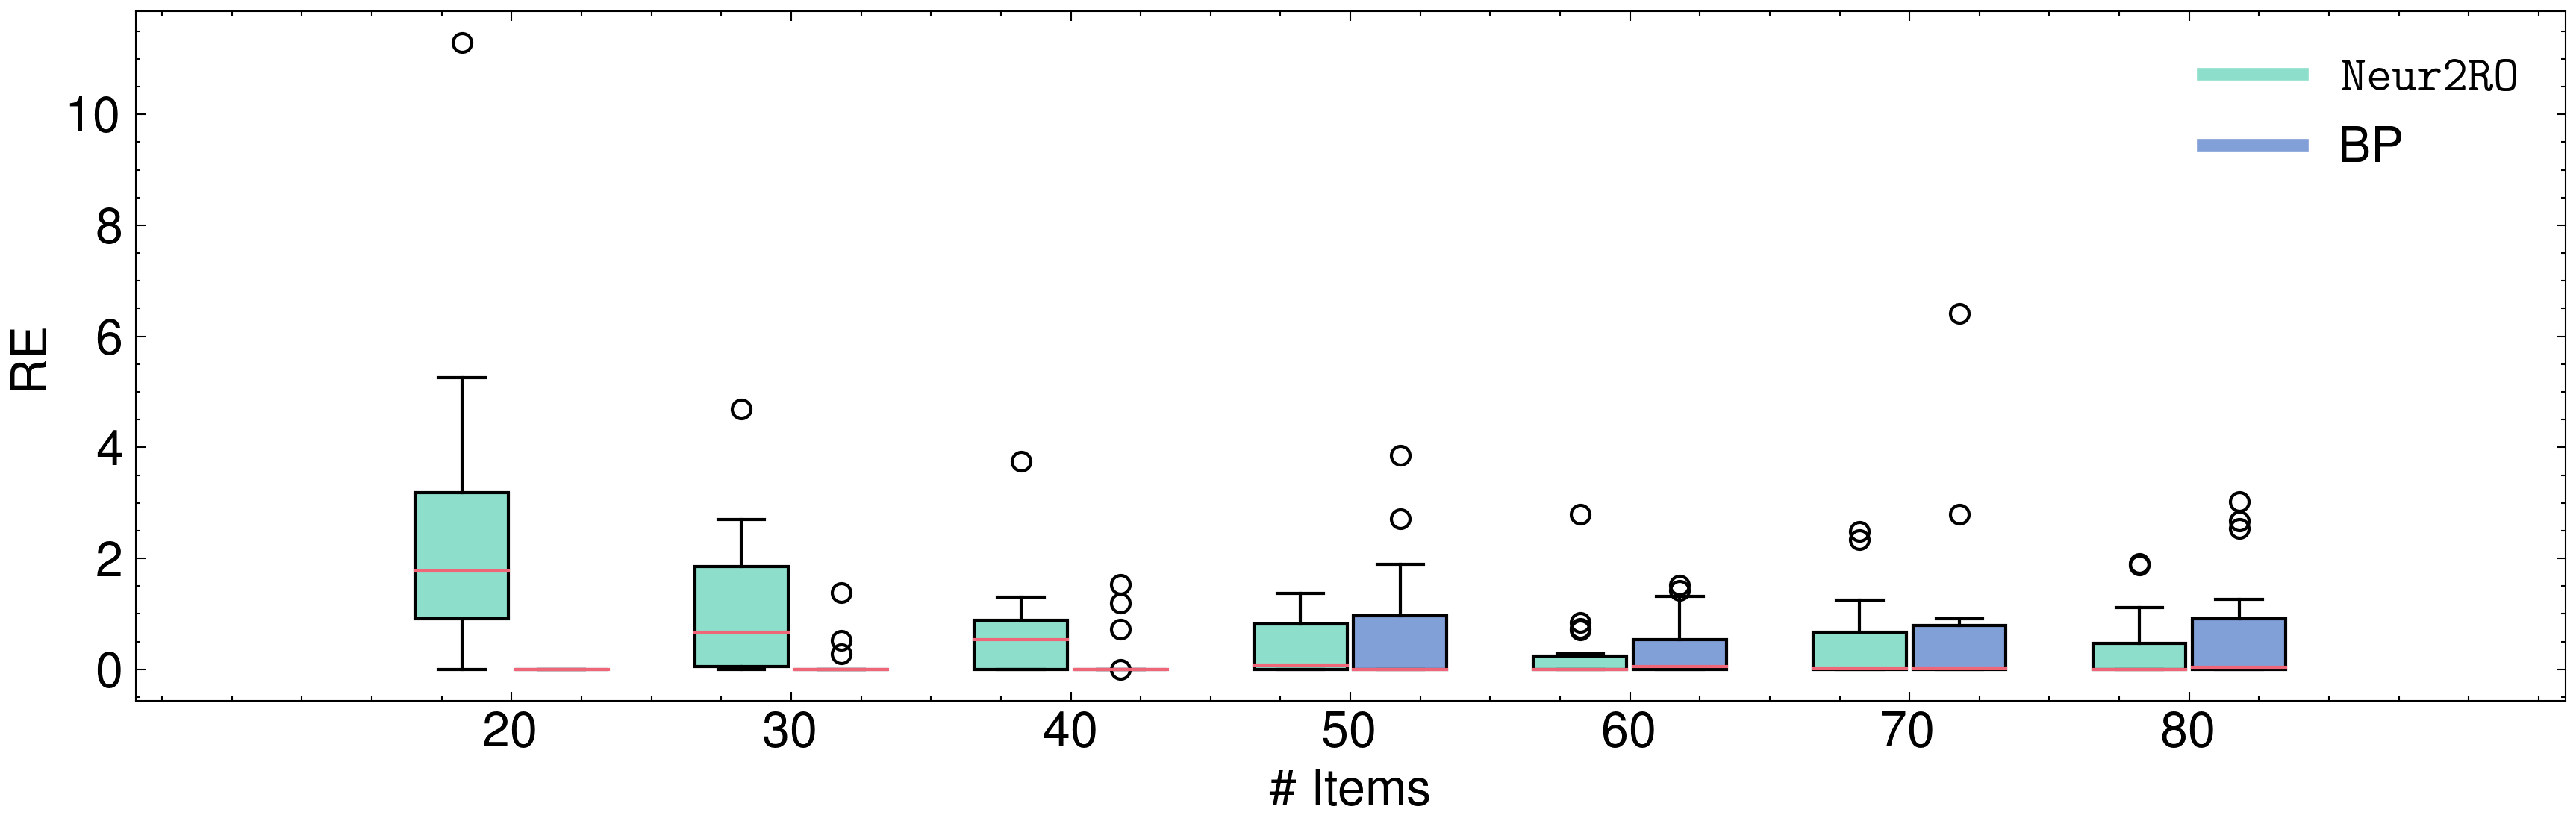

In [25]:
boxplot_for_corr_type("SC")

# Appendix: Tables for distributional information

In [26]:
mp_un = get_main_paper_df_extended(results, 'UN', 'A-AM')
mp_wc = get_main_paper_df_extended(results, 'WC', 'A-AM')
mp_asc = get_main_paper_df_extended(results, 'ASC', 'A-AM')
mp_sc = get_main_paper_df_extended(results, 'SC', 'A-AM')

In [27]:
latex_main_results_extended(mp_un)

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr|rr|rr}
\toprule
 & mean-re-ml & mean-re-baseline & median-re-ml & median-re-baseline & q1-re-ml & q1-re-baseline & q3-re-ml & q3-re-baseline \\
\midrule
20 & 2.005 & \textbf{0.000} & 1.417 & \textbf{0.000} & 0.541 & \textbf{0.000} & 2.379 & \textbf{0.000} \\
30 & 1.189 & \textbf{0.000} & 1.188 & \textbf{0.000} & 0.712 & \textbf{0.000} & 1.399 & \textbf{0.000} \\
40 & 2.895 & \textbf{0.000} & 1.614 & \textbf{0.000} & 1.221 & \textbf{0.000} & 4.042 & \textbf{0.000} \\
50 & 3.055 & \textbf{0.000} & 1.814 & \textbf{0.000} & 0.946 & \textbf{0.000} & 3.801 & \textbf{0.000} \\
60 & 2.106 & \textbf{0.000} & 1.146 & \textbf{0.000} & 0.577 & \textbf{0.000} & 2.872 & \textbf{0.000} \\
70 & 2.228 & \textbf{0.000} & 1.408 & \textbf{0.000} & 0.761 & \textbf{0.000} & 2.514 & \textbf{0.000} \\
80 & 1.595 & \textbf{0.000} & 0.994 & \textbf{0.000} & 0.758 & \textbf{0.000} & 2.063 & \textbf{0.000} \\
\bottomrule
\end{tabular

In [28]:
latex_main_results_extended(mp_wc)

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr|rr|rr}
\toprule
 & mean-re-ml & mean-re-baseline & median-re-ml & median-re-baseline & q1-re-ml & q1-re-baseline & q3-re-ml & q3-re-baseline \\
\midrule
20 & 2.882 & \textbf{0.000} & 1.705 & \textbf{0.000} & 1.260 & \textbf{0.000} & 4.983 & \textbf{0.000} \\
30 & 2.571 & \textbf{0.000} & 2.236 & \textbf{0.000} & 0.616 & \textbf{0.000} & 3.921 & \textbf{0.000} \\
40 & 2.508 & \textbf{0.000} & 1.667 & \textbf{0.000} & 1.180 & \textbf{0.000} & 2.234 & \textbf{0.000} \\
50 & 2.174 & \textbf{0.137} & 1.756 & \textbf{0.000} & 0.793 & \textbf{0.000} & 3.010 & \textbf{0.000} \\
60 & 2.118 & \textbf{0.365} & 0.772 & \textbf{0.000} & \textbf{0.000} & \textbf{0.000} & 1.576 & \textbf{0.458} \\
70 & 0.813 & \textbf{0.338} & 0.068 & \textbf{0.020} & \textbf{0.000} & \textbf{0.000} & 0.715 & \textbf{0.175} \\
80 & \textbf{0.390} & 0.690 & \textbf{0.000} & 0.345 & \textbf{0.000} & \textbf{0.000} & \textbf{0.239} & 0.738 

In [29]:
latex_main_results_extended(mp_asc)

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr|rr|rr}
\toprule
 & mean-re-ml & mean-re-baseline & median-re-ml & median-re-baseline & q1-re-ml & q1-re-baseline & q3-re-ml & q3-re-baseline \\
\midrule
20 & 2.659 & \textbf{0.000} & 1.798 & \textbf{0.000} & 0.072 & \textbf{0.000} & 3.006 & \textbf{0.000} \\
30 & 1.055 & \textbf{0.113} & 0.627 & \textbf{0.000} & 0.054 & \textbf{0.000} & 1.538 & \textbf{0.000} \\
40 & 0.796 & \textbf{0.381} & 0.497 & \textbf{0.000} & 0.019 & \textbf{0.000} & 1.563 & \textbf{0.000} \\
50 & \textbf{0.457} & 0.896 & 0.019 & \textbf{0.000} & \textbf{0.000} & \textbf{0.000} & \textbf{0.673} & 1.396 \\
60 & \textbf{0.214} & 0.454 & 0.047 & \textbf{0.000} & \textbf{0.000} & \textbf{0.000} & \textbf{0.279} & 0.767 \\
70 & \textbf{0.521} & 0.600 & \textbf{0.031} & 0.031 & \textbf{0.000} & \textbf{0.000} & \textbf{0.917} & 1.159 \\
80 & \textbf{0.426} & 0.658 & 0.106 & \textbf{0.035} & \textbf{0.000} & \textbf{0.000} & \textbf{0.543}

In [30]:
latex_main_results_extended(mp_sc)

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr|rr|rr}
\toprule
 & mean-re-ml & mean-re-baseline & median-re-ml & median-re-baseline & q1-re-ml & q1-re-baseline & q3-re-ml & q3-re-baseline \\
\midrule
20 & 2.548 & \textbf{0.000} & 1.774 & \textbf{0.000} & 0.905 & \textbf{0.000} & 3.190 & \textbf{0.000} \\
30 & 1.137 & \textbf{0.121} & 0.670 & \textbf{0.000} & 0.054 & \textbf{0.000} & 1.847 & \textbf{0.000} \\
40 & 0.672 & \textbf{0.191} & 0.542 & \textbf{0.000} & 0.002 & \textbf{0.000} & 0.888 & \textbf{0.000} \\
50 & \textbf{0.413} & 0.648 & 0.073 & \textbf{0.000} & \textbf{0.000} & \textbf{0.000} & \textbf{0.821} & 0.963 \\
60 & \textbf{0.313} & 0.379 & \textbf{0.000} & 0.046 & \textbf{0.000} & \textbf{0.000} & \textbf{0.241} & 0.540 \\
70 & \textbf{0.485} & 0.721 & \textbf{0.020} & 0.027 & \textbf{0.000} & \textbf{0.000} & \textbf{0.668} & 0.793 \\
80 & \textbf{0.363} & 0.638 & \textbf{0.000} & 0.032 & \textbf{0.000} & \textbf{0.000} & \textbf{0.464}

# Appendix:  Ablation

In [31]:
def replace_none_with_0(l):
    new_l = []
    for item in l:
        if item is None:
            new_l.append(0)
        else:
            new_l.append(item)
    return new_l

In [32]:
def fix_baseline_time(l):
    """ Converts to floats and TIME_LIMIT to 3 hours.  """
    new_l = []
    for item in l:
        if item == 'TIME_LIMIT':
            new_l.append(10800)
        else:
            new_l.append(float(item))
    return new_l

In [33]:
def get_df_for_type(results, inst_type, algo_type):
    # rows and columns of dataframe
    n_items = [20, 30, 40, 50, 60, 70, 80]
    cols = [f"gap-{algo_type}", f"mre-{algo_type}", "mre-baseline", f"time-{algo_type}", "Mean Time Baseline", "# Timeouts Baseline", "# Instances", "# Scenarios Added"]
    
    df = pd.DataFrame(columns=cols, index=n_items)

    for n_item in n_items:
        n_item_res = get_inst_agg_results(results, n_item, inst_type)

        df[f"gap-{algo_type}"][n_item] = n_item_res['mean_gap']
        df[f"mre-{algo_type}"][n_item] = n_item_res['mre_ml_mean']
        df[f"mre-baseline"][n_item] = n_item_res['mre_baseline_mean']
        df[f"time-{algo_type}"][n_item] = n_item_res['mean_time_algo']
        df["Mean Time Baseline"][n_item] = n_item_res['mean_time_baseline']
        df["# Timeouts Baseline"][n_item] = n_item_res['n_limits']
        df["# Instances"][n_item] = len(n_item_res['gap'])
        df["# Scenarios Added"][n_item] = n_item_res['n_scenarios']
        
    return df

In [34]:
def get_abaliation_dict(results_am, results_comp, use_baseline=False, use_median=True):
    comp_results = {}

    for corr_type in ["UN", "WC", "ASC", "SC"]:
        comp_results[corr_type] = {}

        for n_items in cfg.n_items:


            res_am = list(filter(lambda x: corr_type in x['inst_name'], results_am[n_items]))
            res_comp = list(filter(lambda x: corr_type in x['inst_name'], results_comp[n_items]))

            res_am = sorted(res_am, key=lambda x: x['inst_name'])
            res_comp = sorted(res_comp, key=lambda x: x['inst_name'])

            obj_baseline = list(map(lambda x: x['baseline_obj'], res_am))
            obj_baseline = list(map(lambda x: float(x), obj_baseline))
            obj_am = list(map(lambda x: x['algo_obj'], res_am))
            obj_comp = list(map(lambda x: x['algo_obj'], res_comp))
            obj_comp = replace_none_with_0(obj_comp)

            best_known = []

            for i in range(len(obj_baseline)):
                if use_baseline:
                    best_known.append(max(obj_baseline[i], obj_am[i], obj_comp[i]))
                else:
                    best_known.append(max(obj_am[i], obj_comp[i]))

            re_baseline = list(map(lambda x, y: 100 * abs(x - y)/y, obj_baseline, best_known))
            re_am = list(map(lambda x, y: 100 * abs(x - y)/y, obj_am, best_known))
            re_comp = list(map(lambda x, y: 100 * abs(x - y)/y, obj_comp, best_known))

            time_baseline = list(map(lambda x: x['baseline_time'], res_am))
            time_baseline = fix_baseline_time(time_baseline)
            time_am = list(map(lambda x: x['algo_time'], res_am))
            time_comp = list(map(lambda x: x['algo_time'], res_comp))

        
            if use_median:
                mre_am = np.median(re_am)
                mre_comp = np.median(re_comp)
            else:
                mre_am = np.mean(re_am)
                mre_comp = np.mean(re_comp)   
                
            comp_results[corr_type][n_items] = {                
                'mre_am' : mre_am,
                'mre_comp' : mre_comp,

                'time_am' : np.mean(time_am),
                'time_comp' : np.mean(time_comp),
            }
            
            if use_baseline:
                if use_median:
                    comp_results[corr_type][n_items]['mre_baseline'] = np.median(mre_baseline)
                else:
                    comp_results[corr_type][n_items]['mre_baseline'] = np.mean(mre_baseline)
                    
                comp_results[corr_type][n_items]['time_baseline'] = np.mean(time_baseline)
                
    return comp_results

In [35]:
def latex_abilaton_df(df_, am_repl, comp_repl):
    """ Generate Latex table for abilation tables.  """

    df = df_.copy()

    df = df.rename(columns={
        'mre_am' : f'{am_repl}',
        'mre_comp' : f'{comp_repl}',
        'time_am' : f'{am_repl}\ ',
        'time_comp' : f'{comp_repl}\ ',
       })
    
    #df = df.style.format(thousands=',', precision=2)     
    
    df = df.style.format(thousands=',', formatter = 
        {f'{am_repl}'     : '{:.3f}'.format,
         f'{comp_repl}'   : '{:.3f}'.format,
         f'{am_repl}\ '   : '{:.0f}'.format,
         f'{comp_repl}\ ' : '{:.0f}'.format,
        })
        
    df = df.highlight_min(subset=[f'{am_repl}', f'{comp_repl}'], props='textbf:--rwrap;', axis=1)
    df = df.highlight_min(subset=[f'{am_repl}\ ', f'{comp_repl}\ '], props='textbf:--rwrap;', axis=1)
    
    end_str = '}\n\\caption{todo}\n'
    end_str += '\\label{tab:todo}\n'
    end_str += '\\end{table*}' 

    latex_str = df.to_latex(column_format='l|rr|rr').replace('_','\_').replace('nan', '-').replace('#', '\#')
    
    latex_str2 = (latex_str.splitlines())
    latex_str2.insert(1, '\\toprule')
    latex_str2.insert(2, '\# items & \multicolumn{2}{c|}{Median RE}  &  \multicolumn{2}{c}{Times} \\\\')
    latex_str2.insert(4, '\\midrule')
    latex_str2.insert(-1, '\\bottomrule')
    latex_str2.insert(0, '\\begin{table*}[h]\\centering\\resizebox{0.8\\textwidth}{!}{')
    latex_str2[-1] += end_str #'}\end{table*}'#.insert(-1, '\\end{tabular}}')

    print("\n".join(latex_str2))
    print()

## Appendix Tables: Argmax vs Max

In [36]:
algo_type = "A-AM"
results_am = get_results(result_dir, algo_type)

In [37]:
algo_type = "A-M"
results_m = get_results(result_dir, algo_type)

In [38]:
comp_results = get_abaliation_dict(results_am, results_m, use_median=True)

In [39]:
latex_abilaton_df(pd.DataFrame(comp_results['UN']).T, 'argmax', 'max')

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr}
\toprule
\# items & \multicolumn{2}{c|}{Median RE}  &  \multicolumn{2}{c}{Times} \\
 & argmax & max & argmax\  & max\  \\
\midrule
20 & \textbf{0.000} & 1.167 & \textbf{7} & 16 \\
30 & \textbf{0.000} & 0.945 & \textbf{9} & 21 \\
40 & \textbf{0.000} & 1.931 & \textbf{13} & 37 \\
50 & \textbf{0.000} & 1.488 & \textbf{14} & 49 \\
60 & \textbf{0.000} & 0.452 & \textbf{24} & 56 \\
70 & \textbf{0.000} & 0.801 & \textbf{27} & 53 \\
80 & \textbf{0.000} & 2.227 & \textbf{20} & 58 \\
\bottomrule
\end{tabular}}
\caption{todo}
\label{tab:todo}
\end{table*}



In [40]:
latex_abilaton_df(pd.DataFrame(comp_results['WC']).T, 'argmax', 'max')

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr}
\toprule
\# items & \multicolumn{2}{c|}{Median RE}  &  \multicolumn{2}{c}{Times} \\
 & argmax & max & argmax\  & max\  \\
\midrule
20 & \textbf{0.000} & 3.515 & \textbf{7} & 22 \\
30 & \textbf{0.000} & 2.405 & \textbf{16} & 37 \\
40 & \textbf{0.000} & 0.455 & \textbf{45} & 59 \\
50 & \textbf{0.000} & 0.254 & \textbf{42} & 73 \\
60 & \textbf{0.000} & 1.528 & 134 & \textbf{100} \\
70 & \textbf{0.000} & 1.769 & \textbf{32} & 57 \\
80 & \textbf{0.000} & 3.492 & \textbf{45} & 85 \\
\bottomrule
\end{tabular}}
\caption{todo}
\label{tab:todo}
\end{table*}



In [41]:
latex_abilaton_df(pd.DataFrame(comp_results['ASC']).T, 'argmax', 'max')

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr}
\toprule
\# items & \multicolumn{2}{c|}{Median RE}  &  \multicolumn{2}{c}{Times} \\
 & argmax & max & argmax\  & max\  \\
\midrule
20 & \textbf{0.000} & 2.042 & \textbf{7} & 18 \\
30 & \textbf{0.000} & 1.433 & \textbf{10} & 23 \\
40 & \textbf{0.000} & 1.739 & \textbf{17} & 51 \\
50 & \textbf{0.000} & 3.161 & \textbf{13} & 34 \\
60 & \textbf{0.000} & 2.449 & \textbf{27} & 48 \\
70 & \textbf{0.000} & 2.497 & \textbf{34} & 52 \\
80 & \textbf{0.000} & 1.824 & \textbf{26} & 53 \\
\bottomrule
\end{tabular}}
\caption{todo}
\label{tab:todo}
\end{table*}



In [42]:
latex_abilaton_df(pd.DataFrame(comp_results['SC']).T, 'argmax', 'max')

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr}
\toprule
\# items & \multicolumn{2}{c|}{Median RE}  &  \multicolumn{2}{c}{Times} \\
 & argmax & max & argmax\  & max\  \\
\midrule
20 & \textbf{0.000} & 1.154 & \textbf{8} & 18 \\
30 & \textbf{0.000} & 0.967 & \textbf{10} & 23 \\
40 & \textbf{0.000} & 1.911 & \textbf{19} & 45 \\
50 & \textbf{0.000} & 3.613 & \textbf{15} & 34 \\
60 & \textbf{0.000} & 2.005 & \textbf{24} & 42 \\
70 & \textbf{0.000} & 2.657 & \textbf{31} & 49 \\
80 & \textbf{0.000} & 2.051 & \textbf{28} & 48 \\
\bottomrule
\end{tabular}}
\caption{todo}
\label{tab:todo}
\end{table*}



## Appendix Tables: Adversarial vs Sampling

In [43]:
algo_type = "A-AM"
results_am = get_results(result_dir, algo_type)

In [44]:
algo_type = "S-AM"
results_s = get_results(result_dir, algo_type)

In [45]:
comp_results = get_abaliation_dict(results_am, results_s)

In [46]:
latex_abilaton_df(pd.DataFrame(comp_results['UN']).T, 'adversarial', 'sampling')

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr}
\toprule
\# items & \multicolumn{2}{c|}{Median RE}  &  \multicolumn{2}{c}{Times} \\
 & adversarial & sampling & adversarial\  & sampling\  \\
\midrule
20 & \textbf{0.000} & \textbf{0.000} & 7 & \textbf{3} \\
30 & \textbf{0.000} & \textbf{0.000} & 9 & \textbf{4} \\
40 & 0.560 & \textbf{0.000} & 13 & \textbf{6} \\
50 & 0.723 & \textbf{0.000} & 14 & \textbf{7} \\
60 & 0.066 & \textbf{0.000} & 24 & \textbf{8} \\
70 & 0.295 & \textbf{0.000} & 27 & \textbf{9} \\
80 & 0.182 & \textbf{0.000} & 20 & \textbf{11} \\
\bottomrule
\end{tabular}}
\caption{todo}
\label{tab:todo}
\end{table*}



In [47]:
latex_abilaton_df(pd.DataFrame(comp_results['WC']).T, 'adversarial', 'sampling')

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr}
\toprule
\# items & \multicolumn{2}{c|}{Median RE}  &  \multicolumn{2}{c}{Times} \\
 & adversarial & sampling & adversarial\  & sampling\  \\
\midrule
20 & \textbf{0.000} & 0.074 & 7 & \textbf{3} \\
30 & \textbf{0.000} & 0.444 & 16 & \textbf{6} \\
40 & \textbf{0.000} & 0.093 & 45 & \textbf{7} \\
50 & 0.441 & \textbf{0.000} & 42 & \textbf{8} \\
60 & \textbf{0.000} & 0.250 & 134 & \textbf{12} \\
70 & \textbf{0.000} & 0.185 & 32 & \textbf{12} \\
80 & \textbf{0.000} & 0.536 & 45 & \textbf{13} \\
\bottomrule
\end{tabular}}
\caption{todo}
\label{tab:todo}
\end{table*}



In [48]:
latex_abilaton_df(pd.DataFrame(comp_results['ASC']).T, 'adversarial', 'sampling')

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr}
\toprule
\# items & \multicolumn{2}{c|}{Median RE}  &  \multicolumn{2}{c}{Times} \\
 & adversarial & sampling & adversarial\  & sampling\  \\
\midrule
20 & \textbf{0.000} & \textbf{0.000} & 7 & \textbf{3} \\
30 & \textbf{0.000} & 0.402 & 10 & \textbf{5} \\
40 & \textbf{0.000} & 0.663 & 17 & \textbf{7} \\
50 & \textbf{0.000} & 0.587 & 13 & \textbf{7} \\
60 & \textbf{0.000} & 0.690 & 27 & \textbf{9} \\
70 & \textbf{0.000} & 0.111 & 34 & \textbf{10} \\
80 & \textbf{0.000} & 0.827 & 26 & \textbf{11} \\
\bottomrule
\end{tabular}}
\caption{todo}
\label{tab:todo}
\end{table*}



In [49]:
latex_abilaton_df(pd.DataFrame(comp_results['SC']).T, 'adversarial', 'sampling')

\begin{table*}[h]\centering\resizebox{0.8\textwidth}{!}{
\begin{tabular}{l|rr|rr}
\toprule
\# items & \multicolumn{2}{c|}{Median RE}  &  \multicolumn{2}{c}{Times} \\
 & adversarial & sampling & adversarial\  & sampling\  \\
\midrule
20 & \textbf{0.000} & \textbf{0.000} & 8 & \textbf{3} \\
30 & \textbf{0.000} & 0.402 & 10 & \textbf{5} \\
40 & \textbf{0.000} & 0.238 & 19 & \textbf{7} \\
50 & \textbf{0.000} & 0.574 & 15 & \textbf{7} \\
60 & \textbf{0.000} & 0.558 & 24 & \textbf{9} \\
70 & \textbf{0.000} & 0.174 & 31 & \textbf{10} \\
80 & \textbf{0.000} & 0.548 & 28 & \textbf{11} \\
\bottomrule
\end{tabular}}
\caption{todo}
\label{tab:todo}
\end{table*}



# Appendix: Data collection

In [50]:
with open(fp_data, 'rb') as p:
    ml_data = pkl.load(p)

In [51]:
print("Time data collection:", ml_data['total_time'])

Time data collection: 2162.646444797516


# Appendix: Training

In [52]:
with open(fp_nn_res, 'rb') as p:
    tr_res = pkl.load(p)

In [53]:
print("Time (training):", tr_res["train_time"])

Time (training): 2978.9508447647095


In [54]:
eps = range(1,500, 10)
tr_maes = tr_res['training_stats']['tr_maes']
val_maes = tr_res['training_stats']['val_maes']

In [55]:
colors = ['#82A0D8', 'r',]
fontsize = 16

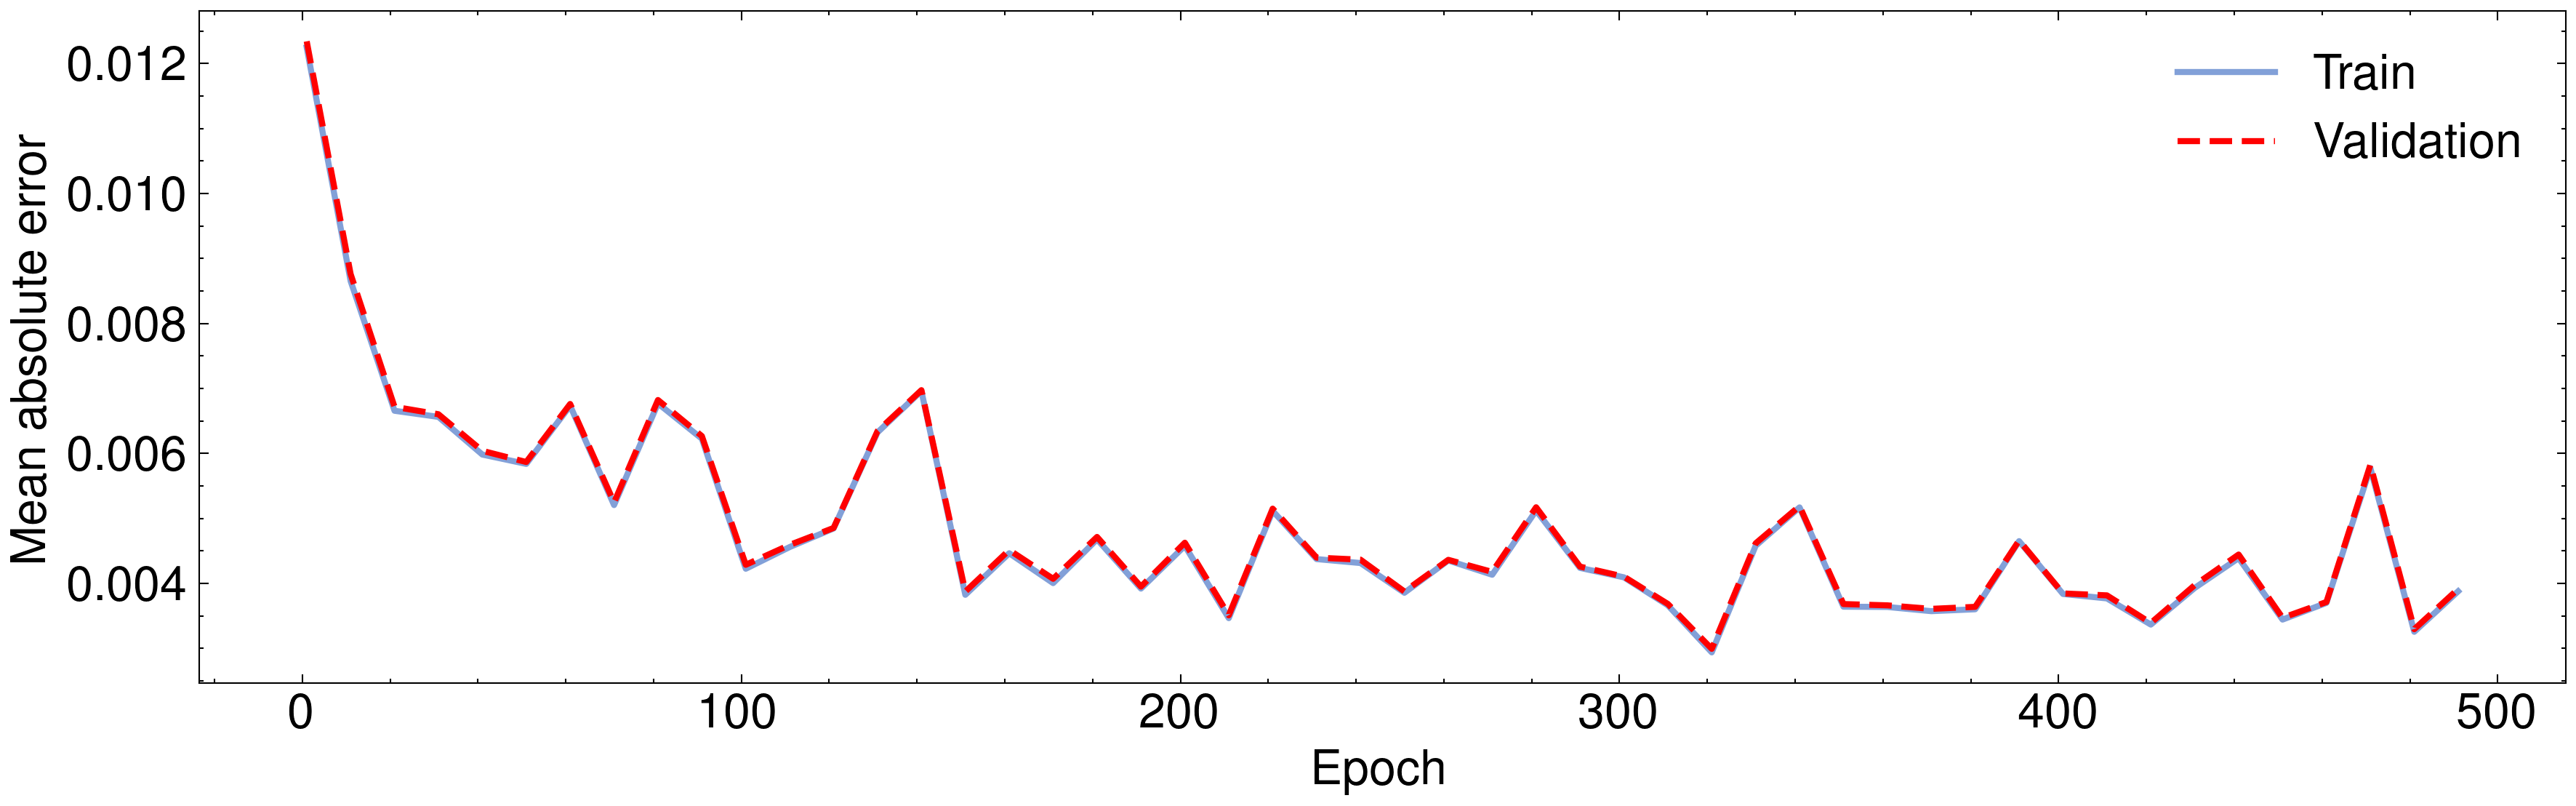

In [56]:
with plt.style.context(['science', 'nature', 'bright']):
    
    fig, ax = plt.subplots(figsize=(14,4), dpi=300)
    
    plt.plot(eps, tr_maes, label = 'Train', color=colors[0], lw=2, alpha=1)
    plt.plot(eps, val_maes, label = 'Validation', color=colors[1], lw=2, alpha=1,linestyle='dashed')
    
    ax.legend(fontsize=fontsize)
    ax.set_ylabel('Mean absolute error', fontsize=fontsize)
    ax.set_xlabel('Epoch', fontsize=fontsize)

    plt.yticks(fontsize=fontsize)  
    plt.xticks(fontsize=fontsize) 

    plt.show()